In [89]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
iters = 1000
n_samp = 1000
n_feat = 100
n_fold = 10
std = 1

pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('svm', SVC(kernel='linear'))
                ])

skf = StratifiedKFold(n_splits=n_fold)
results = {'accuracy': [],
           'init_corr': [],
           'sign_change': [],
           'corr_diff': []}

acc = np.zeros((iters, n_fold))
for i in range(iters):
    data = np.random.normal(0, std, size=(n_samp, n_feat + 1))
    data[:, -1] = (data[:, -1] > np.median(data[:, -1])).astype(int)
    X, y = data[:, :-1], data[:, -1]
    
    results['init_corr'].append(np.abs(np.corrcoef(data.T))[-1, :-1].mean())
    
    corr_diff = np.zeros(n_fold)
    sign_changes = np.zeros(n_fold)
    for ii, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        corr_train = np.corrcoef(np.hstack((X_train, y_train[:, np.newaxis])).T)[-1, :-1]
        corr_test = np.corrcoef(np.hstack((X_test, y_test[:, np.newaxis])).T)[-1, :-1]
        sign_changes[ii] = (np.sign(corr_train) != np.sign(corr_test)).sum() / n_fold
        corr_diff[ii] = np.abs(corr_train - corr_test).mean()
        
        pipe.fit(X_train, y_train)
        acc[i, ii] = pipe.score(X_test, y_test)
    results['accuracy'].append(acc[i, :].mean())
    results['sign_change'].append(sign_changes.mean())
    results['corr_diff'].append(corr_diff.mean())

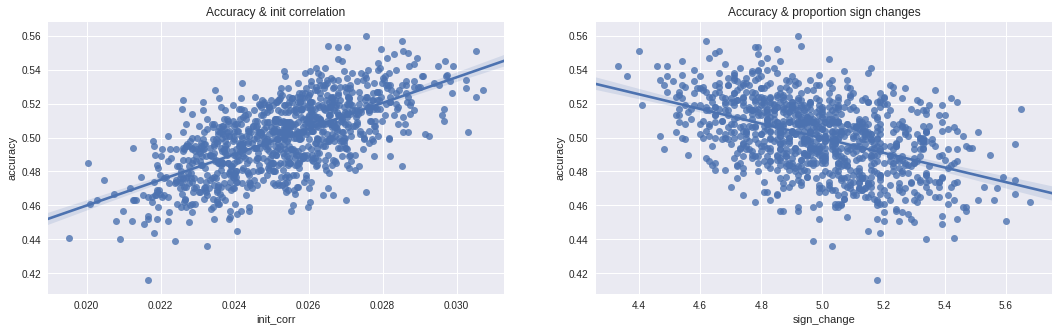

In [127]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy & init correlation')
sns.regplot(y='accuracy', x='init_corr', data=pd.DataFrame(results), )
plt.subplot(1, 2, 2)
plt.title('Accuracy & proportion sign changes')
sns.regplot(y='accuracy', x='sign_change', data=pd.DataFrame(results))
plt.show()